# Underway plots

This notebook generates 'underway' plots for the Denman/Shackleton region. Model output is used to generate plots of oceangraphic conditions for a certain day.

**Requirements:** All notebooks need to run on the `conda/analysis3` kernel. This is the most recent stable release of the `conda` environment curated by the CLEX CMS team.

First, we load any required modules. The following are pretty standard:

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as feature
import cmocean as cm
import intake
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import numpy as np
import xarray as xr
from xgcm import Grid

from dask.distributed import Client



I found that sometimes dask doesn't play nice with xgcm, so let's use it for now, but possibly comment it out if we get weird xgcm issues.

In [2]:
# client = Client(threads_per_worker=1)
# client

In [3]:
# import warnings

# warnings.simplefilter("ignore", category=RuntimeWarning)
# warnings.simplefilter("ignore", category=FutureWarning)

Open ACCESS-NRI default catalog

In [4]:
import intake
cat = intake.cat.access_nri


Choose the Shackleton ROMS output, which has 5-day snapshots.

In [5]:
exp_key = "shackleton_v4_jk72"   # new experiment datastore
start_time = '2026-01-01'
end_time = '2031-12-31'

In [6]:
# find the shackleton dataset
exp = cat[exp_key]
print(exp)

<shackleton_v4_jk72 catalog with 1 dataset(s) from 26 asset(s)>


<!-- For this recipe we will just load 1 year of daily velocities, but if you want to do the decomposition with output longer than, e.g., 1 year then we suggest you either convert this to a `.py` script and submit through the queue via `qsub` or figure a way to scale `dask` up to larger `ncpus`. -->

In [7]:
# load data
method='intake'

if method=='intake':
    ds = cat[exp_key].search(
                        frequency="5day",
                        ).to_dask(xarray_combine_by_coords_kwargs = {
        "coords" : "minimal",
        "compat" : 'override',
        "data_vars" : 'minimal'
    })
    
    # and subset the last 5 years
    ds = ds.sel(ocean_time=slice(start_time, end_time))
elif method=='local':
    # simple method for loading his files - replace with intake catalog method.and
    import glob
    FilePath='/g/data/jk72/deg581/shacom/mdl/shackleton_v4/' # Truth file settings
    prefix='roms_his_'
    
    
    filelist = glob.glob(FilePath+prefix+'002*.nc')
    ds = xr.open_mfdataset(filelist,{'ocean_time':1}, data_vars='minimal',compat='override',coords='minimal',parallel=True, join='right')

Prepare the ROMS dataset for use.

In [8]:
# do special processing for ROMS formatting

def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    grid = Grid(ds,
                coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
                'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
                'Z':{'center':'s_rho', 'outer':'s_w'}},
                periodic=[])

    

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + (ds.zeta+ds.zice) * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + (ds.zeta+ds.zice) * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta+ds.zice + (ds.zeta+ds.zice + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta+ds.zice + ds.h) + ds.zeta + ds.zice

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    ds["z_rho0"] = ds.z_rho0.fillna(0)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    return ds



def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut


ds = processROMSGrid(ds)
grid = makeROMSGridObject(ds)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return

Make some other masks that we might need.

In [9]:
mask_zice = ds.mask_rho.where((ds.zice < 0)&(ds.mask_rho==1),0)
mask_ziceNaN = mask_zice.where(mask_zice==1,np.nan)

Make a climatology from the input files, and add a new coordinate which has date values for 2025 for the dayofyear index.

In [10]:

ds_clima = ds.groupby('ocean_time.dayofyear').mean('ocean_time')

dates = np.array([np.datetime64(f"{2025}-01-01") + np.timedelta64(int(doy - 1), "D") for doy in ds_clima.dayofyear.values])

ds_clima = ds_clima.assign_coords(date=("dayofyear", dates.astype("datetime64[ns]")))
ds_clima = ds_clima.swap_dims({"dayofyear": "date"})

Make new dataset with just the variables we're interested in.

In [11]:

my = (ds_clima.m*60*60*24*365) # make melt rate into m/year

ubar = grid.interp(ds_clima.ubar, 'X')
vbar = grid.interp(ds_clima.vbar, 'Y')


u = grid.interp(ds_clima.u, 'X')
v = grid.interp(ds_clima.v, 'Y')

temp = ds_clima.temp
salt = ds_clima.salt

# # load the lon/lat values for the x_rho/y_rho PSG points
# ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
# lat_rho, lon_rho = ps_to_ll.transform(ds.x_rho.values, ds.y_rho.values)

# Create a new dataset
ds_shackleton = xr.Dataset(
    {
        "my": my,
        "ubar": ubar,
        "vbar": vbar,
        "u":u,
        "v": v,
        "temp": temp,
        "salt":salt,
        "z_rho0": ds.z_rho0,
        # "lon_rho": (["eta_rho", "xi_rho"], lon_rho),
        # "lat_rho": (["eta_rho", "xi_rho"], lat_rho),
        "x_rho":  ds.x_rho,
        "y_rho": ds.y_rho,
        "mask_rho":ds.mask_rho,
        "mask_zice":mask_zice,
        "mask_ziceNaN":mask_ziceNaN,
        "h": ds.h,
        "zice": ds.zice,
        "angle": ds.angle,
    },
    coords={
        "date": ds_clima.date,
        "xi_rho": ds_clima.xi_rho,
        "eta_rho": ds_clima.eta_rho,
        "s_rho": ds_clima.s_rho,
    }
)

# ds_shackleton = ds_shackleton.assign_coords({"x_rho": ds_shackleton.x_rho})
# ds_shackleton = ds_shackleton.assign_coords({"y_rho": ds_shackleton.y_rho})


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return

It might make more sense to load the dataset, so that we can plot faster.

In [13]:
%%time
ds_shackleton.load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: overflow encountered in multiply
  return self.func(*new_argspec)


CPU times: user 7min 9s, sys: 6min 58s, total: 14min 8s
Wall time: 3min


<xarray.Dataset> Size: 7GB
Dimensions:       (eta_rho: 310, xi_rho: 295, date: 147, s_rho: 31)
Coordinates:
    grid          int32 4B 1
    x_rho         (eta_rho, xi_rho) float64 732kB 2.476e+06 ... 3.064e+06
    y_rho         (eta_rho, xi_rho) float64 732kB -7.49e+05 ... -1.31e+05
    lon_rho       (eta_rho, xi_rho) float64 732kB 106.8 106.8 ... 92.45 92.45
    lat_rho       (eta_rho, xi_rho) float64 732kB -66.51 -66.5 ... -62.32 -62.3
    dayofyear     (date) int64 1kB 1 5 6 10 11 15 16 ... 355 356 360 361 365 366
  * date          (date) datetime64[ns] 1kB 2025-01-01 2025-01-05 ... 2026-01-01
  * xi_rho        (xi_rho) int64 2kB 0 1 2 3 4 5 6 ... 289 290 291 292 293 294
  * eta_rho       (eta_rho) int64 2kB 0 1 2 3 4 5 6 ... 304 305 306 307 308 309
  * s_rho         (s_rho) float64 248B -0.9839 -0.9516 ... -0.04839 -0.01613
    z_rho0        (eta_rho, xi_rho, s_rho) float64 23MB 0.0 0.0 ... -5.897
Data variables: (12/13)
    my            (date, eta_rho, xi_rho) float32 54MB inf inf inf ... 0.0 0.0
    ubar          (date, eta_rho, xi_rho) float32 54MB nan nan ... 0.007442 nan
    vbar          (date, eta_rho, xi_rho) float32 54MB nan nan ... -0.02325
    u             (date, s_rho, eta_rho, xi_rho) float32 2GB nan nan ... nan
    v             (date, s_rho, eta_rho, xi_rho) float32 2GB nan ... -0.04706
    temp          (date, s_rho, eta_rho, xi_rho) float32 2GB nan nan ... -0.6738
    ...            ...
    mask_rho      (eta_rho, xi_rho) float64 732kB 0.0 0.0 0.0 ... 1.0 1.0 1.0
    mask_zice     (eta_rho, xi_rho) float64 732kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mask_ziceNaN  (eta_rho, xi_rho) float64 732kB nan nan nan ... nan nan nan
    h             (eta_rho, xi_rho) float64 732kB 74.13 75.82 ... 3e+03 3e+03
    zice          (eta_rho, xi_rho) float64 732kB -39.13 0.0 0.0 ... 0.0 0.0 0.0
    angle         (eta_rho, xi_rho) float64 732kB 1.865 1.864 ... 1.614 1.614

Now let's make some plots for analysis of daily conditions (from the climatology!)

First, set the date:

In [14]:
choose_day = '2025-03-01'


Spatial maps at current date

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


Text(0.5, 1.0, 'Potential temperature for day: 2025-03-01\nwith currents at: 10 m depth')

<Figure size 640x480 with 0 Axes>

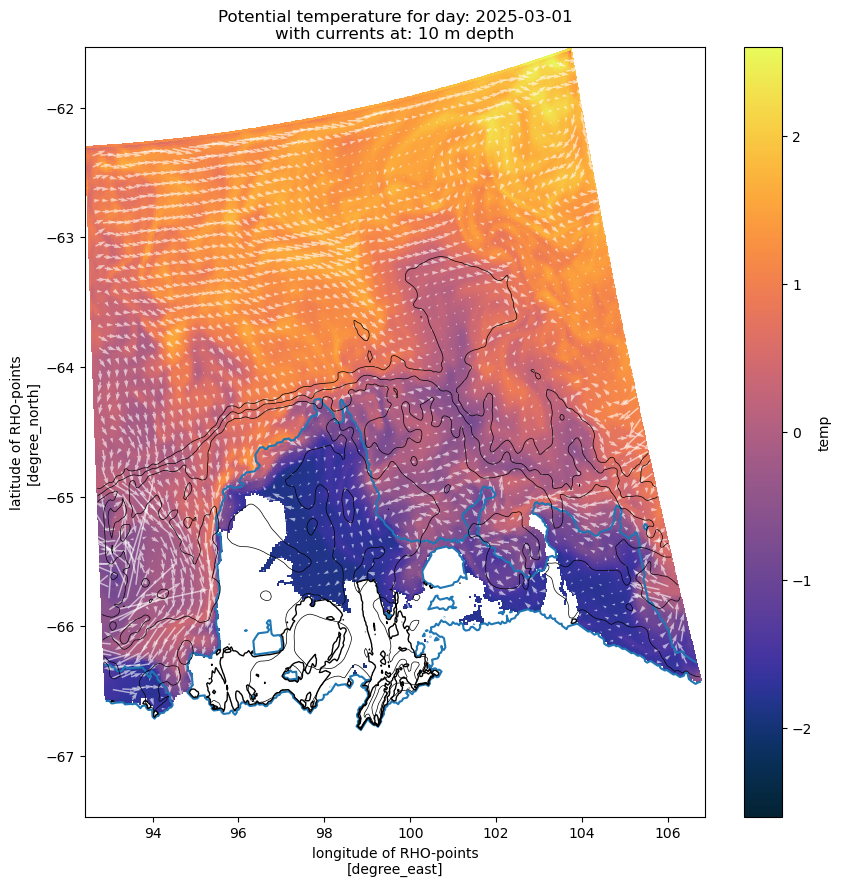

In [15]:
choose_depth = 10 #metres

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.17, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,10])
ax = None


ax = fig.add_subplot(gs[0,0])

#extract data at nearest depth

temp_depth = grid.transform(ds_shackleton.temp.sel(date=choose_day,method='nearest'),
                         'Z', np.array([-choose_depth]),
                         target_data=ds_shackleton.z_rho0,method='linear').squeeze()

u_depth = grid.transform(ds_shackleton.u.sel(date=choose_day,method='nearest'),
                         'Z', np.array([-choose_depth]),
                         target_data=ds_shackleton.z_rho0,method='linear').squeeze()

v_depth = grid.transform(ds_shackleton.v.sel(date=choose_day,method='nearest'),
                         'Z', np.array([-choose_depth]),
                         target_data=ds_shackleton.z_rho0,method='linear').squeeze()

U = u_depth + 1j*v_depth
rotation_factor = np.exp(1j*ds_shackleton.angle)
rotated_velocity = U * rotation_factor
# Extract the real and imaginary parts (rotated u and v components)
u_lonlat = np.real(rotated_velocity)
v_lonlat = np.imag(rotated_velocity)


im = temp_depth.plot(x='lon_rho',y='lat_rho',cmap='cmo.thermal')
res=5
qu = ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res],ds_shackleton.lat_rho.values[0::res,0::res],u_lonlat[0::res,0::res],v_lonlat[0::res,0::res],scale=5,color='w',alpha=0.6)

# add decorations
(ds_shackleton.zice*ds_shackleton.mask_rho).plot.contour(x='lon_rho',y='lat_rho',colors='C0',levels=[-1,0],linestyles='-')
co = (ds_shackleton.zice*ds_shackleton.mask_rho).plot.contour(x='lon_rho',y='lat_rho',colors='k',levels=[-1000,-500,-250],linestyles='-',linewidths=1)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(x='lon_rho',y='lat_rho',colors='k',levels=[500,1000,1500],linestyles='-',linewidths=0.5)

title = 'Potential temperature for day: '+choose_day+'\n'+'with currents at: '+str(choose_depth)+' m depth'
ax.set_title(title)


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


Text(0.5, 1.0, 'Potential temperature for day: 2025-03-01\nwith currents at: 450 m depth')

<Figure size 640x480 with 0 Axes>

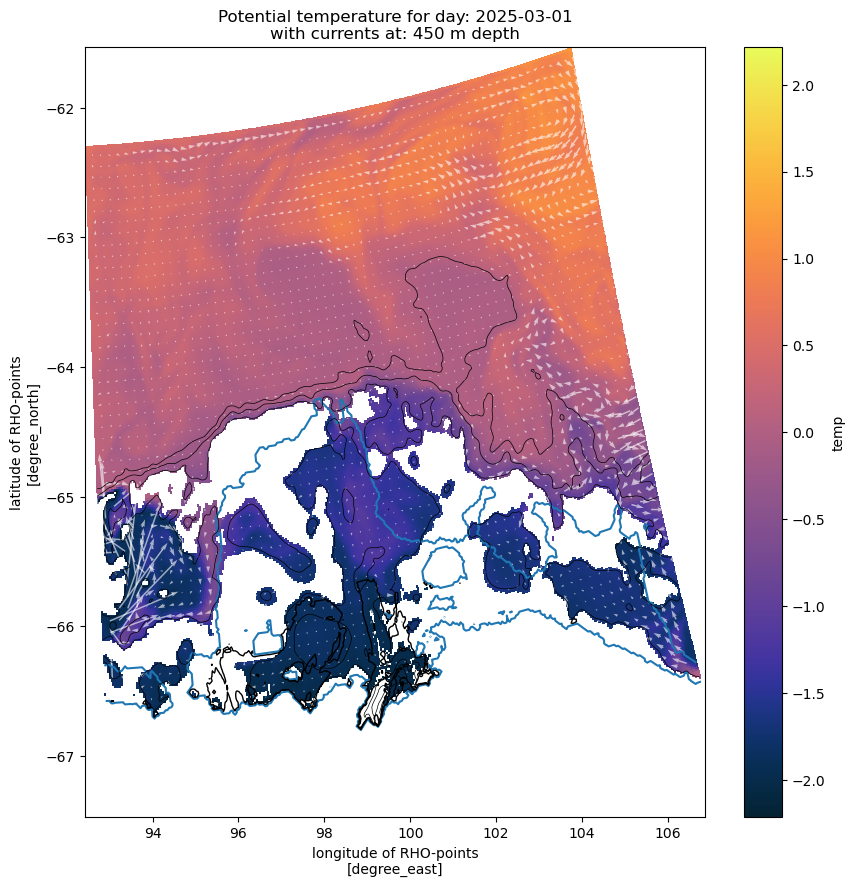

In [16]:
choose_depth = 450 #metres
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.17, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,10])
ax = None


ax = fig.add_subplot(gs[0,0])

#extract data at nearest depth

temp_depth = grid.transform(ds_shackleton.temp.sel(date=choose_day,method='nearest'),
                         'Z', np.array([-choose_depth]),
                         target_data=ds_shackleton.z_rho0,method='linear').squeeze()

u_depth = grid.transform(ds_shackleton.u.sel(date=choose_day,method='nearest'),
                         'Z', np.array([-choose_depth]),
                         target_data=ds_shackleton.z_rho0,method='linear').squeeze()

v_depth = grid.transform(ds_shackleton.v.sel(date=choose_day,method='nearest'),
                         'Z', np.array([-choose_depth]),
                         target_data=ds_shackleton.z_rho0,method='linear').squeeze()

U = u_depth + 1j*v_depth
rotation_factor = np.exp(1j*ds_shackleton.angle)
rotated_velocity = U * rotation_factor
# Extract the real and imaginary parts (rotated u and v components)
u_lonlat = np.real(rotated_velocity)
v_lonlat = np.imag(rotated_velocity)


im = temp_depth.plot(x='lon_rho',y='lat_rho',cmap='cmo.thermal')
res=5
qu = ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res],ds_shackleton.lat_rho.values[0::res,0::res],u_lonlat[0::res,0::res],v_lonlat[0::res,0::res],scale=5,color='w',alpha=0.6)

# add decorations
(ds_shackleton.zice*ds_shackleton.mask_rho).plot.contour(x='lon_rho',y='lat_rho',colors='C0',levels=[-1,0],linestyles='-')
co = (ds_shackleton.zice*ds_shackleton.mask_rho).plot.contour(x='lon_rho',y='lat_rho',colors='k',levels=[-1000,-500,-250],linestyles='-',linewidths=1)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(x='lon_rho',y='lat_rho',colors='k',levels=[500,1000,1500],linestyles='-',linewidths=0.5)

title = 'Potential temperature for day: '+choose_day+'\n'+'with currents at: '+str(choose_depth)+' m depth'
ax.set_title(title)



For a certain longitude, extract profiles. Because the grid is on the polarstereographic cartesian projection, model eta/xi coordinates do not align with lines of latitude or longitude. As such, we need to extract the closest points. We use a function that looks for the closest point at each latitude, then extracts all of these points (indices) from the dataset.

In [17]:

def extract_along_longitude(ds, choose_lon, var_name):
    """
    Extract values from a 3D ROMS variable along the closest longitude at each latitude.
    
    Parameters:
    ds (xarray.Dataset): The ROMS dataset containing 'lon_rho' and the variable of interest.
    choose_lon (float): The target longitude for extraction.
    var_name (str): The name of the 3D variable to extract (e.g., 'temp', 'salt', 'zeta').

    Returns:
    xarray.DataArray: Extracted values along the closest longitude at each latitude.
    """
    # Get longitude grid
    lon_rho = ds['lon_rho'].values

    # Compute absolute differences to target longitude
    lon_index_2d = np.abs(lon_rho - choose_lon)

    # Initialize an array for closest longitude indices (one per latitude row)
    lon_index = np.zeros(lon_index_2d.shape[1], dtype=int)

    # Loop over each latitude row and find the closest longitude index
    for ii in range(lon_index_2d.shape[1]):
        lon_index[ii] = lon_index_2d[:, ii].argmin()

    # Create latitude indices (row indices)
    lat_index = np.arange(lon_index_2d.shape[1])

    # Extract the 3D variable
    variable_3d = ds[var_name]

    # Use xarray advanced indexing to extract the values
    extracted_values = variable_3d.isel(eta_rho=(['points'], lon_index), xi_rho=(['points'], lat_index))

    return extracted_values


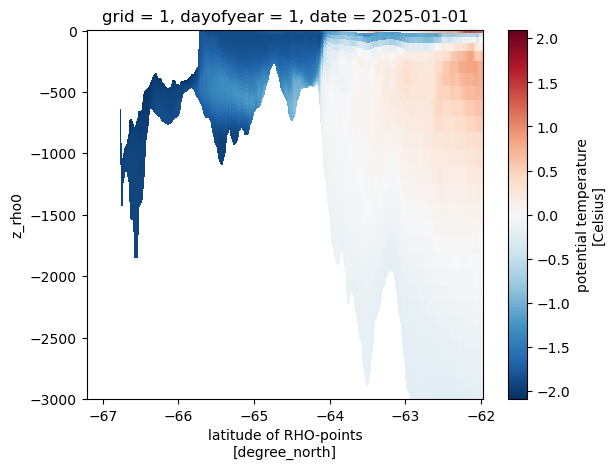

In [18]:
extracted_data = extract_along_longitude(ds_shackleton, choose_lon=99.25, var_name='temp')

# This will return an xarray DataArray with dimensions (time, points)
extracted_data.isel(date=0).plot(y='z_rho0',x='lat_rho')

So let's make some nice plots of cross-shelf properties.

Text(0, 0.5, 'Depth (m)')

<Figure size 640x480 with 0 Axes>

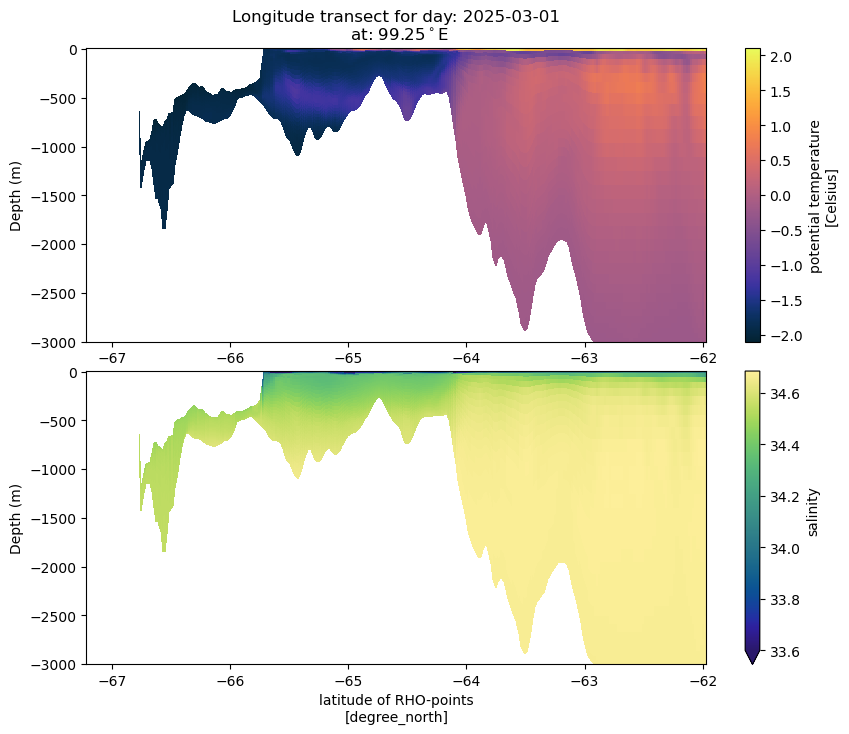

In [19]:
lon_transect = 99.25 #deg
extracted_data = extract_along_longitude(ds_shackleton, choose_lon=lon_transect, var_name='temp')

# This will return an xarray DataArray with dimensions (time, points)
extracted_data.isel(date=0).plot(y='z_rho0',x='lat_rho')

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.17, hspace=0.1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,8])
ax = None


ax = fig.add_subplot(gs[0,0])

extract_along_longitude(ds_shackleton, choose_lon=lon_transect, var_name='temp').sel(
                    date=choose_day,method='nearest').plot(y='z_rho0',x='lat_rho',cmap='cmo.thermal')

title = 'Longitude transect for day: '+choose_day+'\n'+' at: '+str(lon_transect)+r'$^\circ$E'
ax.set_title(title)
ax.set_ylabel('Depth (m)')

ax = fig.add_subplot(gs[1,0])

extract_along_longitude(ds_shackleton, choose_lon=lon_transect, var_name='salt').sel(
                    date=choose_day,method='nearest').plot(y='z_rho0',x='lat_rho',cmap='cmo.haline',vmin=33.6)
ax.set_title('')
ax.set_ylabel('Depth (m)')



Text(0, 0.5, 'Depth (m)')

<Figure size 640x480 with 0 Axes>

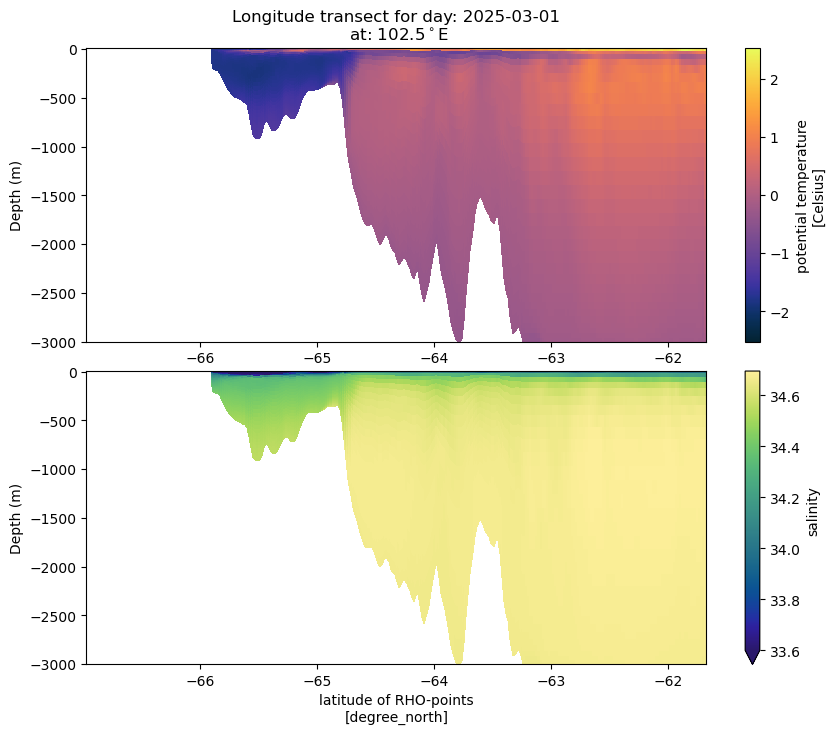

In [20]:
lon_transect = 102.5 #deg
extracted_data = extract_along_longitude(ds_shackleton, choose_lon=lon_transect, var_name='temp')

# This will return an xarray DataArray with dimensions (time, points)
extracted_data.isel(date=0).plot(y='z_rho0',x='lat_rho')

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.17, hspace=0.1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,8])
ax = None


ax = fig.add_subplot(gs[0,0])

extract_along_longitude(ds_shackleton, choose_lon=lon_transect, var_name='temp').sel(
                    date=choose_day,method='nearest').plot(y='z_rho0',x='lat_rho',cmap='cmo.thermal')

title = 'Longitude transect for day: '+choose_day+'\n'+' at: '+str(lon_transect)+r'$^\circ$E'
ax.set_title(title)
ax.set_ylabel('Depth (m)')

ax = fig.add_subplot(gs[1,0])

extract_along_longitude(ds_shackleton, choose_lon=lon_transect, var_name='salt').sel(
                    date=choose_day,method='nearest').plot(y='z_rho0',x='lat_rho',cmap='cmo.haline',vmin=33.6)
ax.set_title('')
ax.set_ylabel('Depth (m)')

